# RESNET CODE

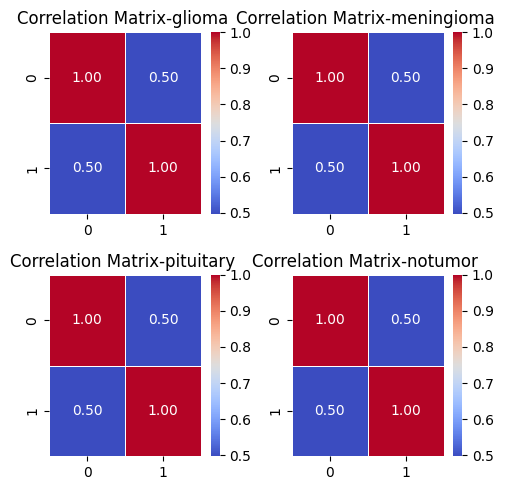

In [7]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from itertools import combinations

# Define the root folders containing subfolders for training and testing sets
root_data_path_train = '/kaggle/input/brain-tumor-mri-dataset/Training'
root_data_path_test = '/kaggle/input/brain-tumor-mri-dataset/Testing'

# Define classes (replace 'no_tumor' with 'notumor')
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Function to generate image paths
def generate_image_paths(root_folder, classes):
    image_paths = []
    for class_name in classes:
        class_folder = os.path.join(root_folder, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            if os.path.isfile(img_path):
                image_paths.append(img_path)
    return image_paths

# Function to compute the Pearson correlation matrix
def compute_correlation_matrix(image_paths, sample_size=100):
    image_combinations = combinations(image_paths, 2)
    num_samples = 0
    correlation_sum = None

    for img1_path, img2_path in image_combinations:
        img1 = io.imread(img1_path)
        img2 = io.imread(img2_path)
        
        if img1.shape != img2.shape:
            continue

        if correlation_sum is None:
            correlation_sum = np.corrcoef(img1.flatten(), img2.flatten())
        else:
            correlation_sum += np.corrcoef(img1.flatten(), img2.flatten())

        num_samples += 1
        if num_samples >= sample_size:
            break

    correlation_matrix = correlation_sum / num_samples
    return correlation_matrix

# Generator for loading and processing images
def image_generator(root_folder, classes, sample_size=100):
    image_paths = generate_image_paths(root_folder, classes)
    while True:
        correlation_matrix = compute_correlation_matrix(image_paths, sample_size)
        yield correlation_matrix

# Plot the correlation matrices
plt.figure(figsize=(5, 5))
image_gen = image_generator(root_data_path_train, classes)

for i, class_name in enumerate(classes, start=1):
    plt.subplot(2, 2, i)
    correlation_matrix = next(image_gen)
    sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".2f")
    plt.title(f'Correlation Matrix-{class_name} ')


plt.tight_layout()
plt.show()


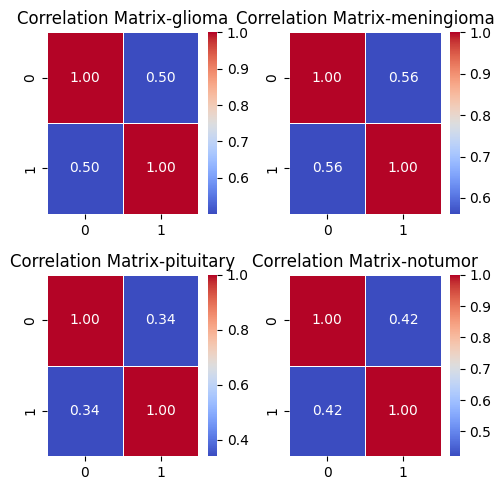

In [8]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from itertools import combinations

# Define the root folder containing subfolders for training and testing sets
root_data_path_train = '/kaggle/input/brain-tumor-mri-dataset/Training'

# Define classes
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']

# Function to generate image paths for a given class
def generate_image_paths(class_folder):
    return [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

# Function to compute the Pearson correlation matrix for a list of image paths
def compute_correlation_matrix(image_paths, sample_size=100):
    correlation_sum = np.zeros((2, 2))  # Initialize correlation sum matrix
    num_samples = 0

    for img1_path, img2_path in combinations(image_paths, 2):
        img1 = io.imread(img1_path, as_gray=True)
        img2 = io.imread(img2_path, as_gray=True)

        if img1.shape != img2.shape:
            continue

        correlation_sum += np.corrcoef(img1.flatten(), img2.flatten())
        num_samples += 1

        if num_samples >= sample_size:
            break

    correlation_matrix = correlation_sum / num_samples
    return correlation_matrix

# Plot the correlation matrices
plt.figure(figsize=(5, 5))

for i, class_name in enumerate(classes, start=1):
    class_folder = os.path.join(root_data_path_train, class_name)
    image_paths = generate_image_paths(class_folder)
    correlation_matrix = compute_correlation_matrix(image_paths)
    
    plt.subplot(2, 2, i)
    sns.heatmap(correlation_matrix, cmap='coolwarm', linewidths=0.5, annot=True, fmt=".2f")
    plt.title(f'Correlation Matrix-{class_name}')

plt.tight_layout()
plt.show()


In [1]:
#RESNET CODE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# Define the root folder containing subfolders for each class
root_data_path = '/kaggle/input/brain-tumor-mri-dataset'

# Define data transformations with increased augmentation and color jitter
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset using ImageFolder
brain_tumor_dataset = datasets.ImageFolder(root=root_data_path + '/Training', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(brain_tumor_dataset))
val_size = len(brain_tumor_dataset) - train_size
train_dataset, val_dataset = random_split(brain_tumor_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet-50 weights from a local file
local_weights_path = '/kaggle/input/pthfiles/resnet50-0676ba61.pth'
resnet_weights = torch.load(local_weights_path)

# Load ResNet-50 model and load the weights
resnet = models.resnet50()
resnet.load_state_dict(resnet_weights)

# Modify ResNet classifier to fit the number of classes in your dataset
num_classes = len(brain_tumor_dataset.classes)
resnet.fc = nn.Sequential(
    nn.Flatten(),
    nn.Dropout(0.5),
    nn.Linear(resnet.fc.in_features, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, num_classes)
)


# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.8, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

# Training loop with early stopping
prev_val_loss = float('inf')
early_stopping_count = 0
max_early_stopping = 3  # Maximum number of epochs without improvement for early stopping

num_epochs = 10 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}')

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Adjust learning rate
    scheduler.step()

    # Early stopping
    if avg_val_loss >= prev_val_loss:
        early_stopping_count += 1
        if early_stopping_count >= max_early_stopping:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            break
    else:
        early_stopping_count = 0

    prev_val_loss = avg_val_loss

# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_detection_resnet_model.pth')


Epoch 1/10, Average Loss: 1.3457942450796807
Epoch 1/10, Validation Loss: 1.2336420449945662, Accuracy: 0.4671916010498688
Epoch 2/10, Average Loss: 1.0789047717214464
Epoch 2/10, Validation Loss: 0.7613548934459686, Accuracy: 0.7217847769028871
Epoch 3/10, Average Loss: 0.6546776974117839
Epoch 3/10, Validation Loss: 0.3999059903952811, Accuracy: 0.8678915135608049
Epoch 4/10, Average Loss: 0.3934166099016483
Epoch 4/10, Validation Loss: 0.2589851940671603, Accuracy: 0.9125109361329834
Epoch 5/10, Average Loss: 0.29118995092340283
Epoch 5/10, Validation Loss: 0.22116684623890454, Accuracy: 0.9247594050743657
Epoch 6/10, Average Loss: 0.2556142302138822
Epoch 6/10, Validation Loss: 0.18918101023882627, Accuracy: 0.9335083114610674
Epoch 7/10, Average Loss: 0.2067606853438424
Epoch 7/10, Validation Loss: 0.1544302069168124, Accuracy: 0.9396325459317585
Epoch 8/10, Average Loss: 0.1798267335845874
Epoch 8/10, Validation Loss: 0.12222673723267184, Accuracy: 0.9623797025371829
Epoch 9/10, 

Overall Evaluation Metrics:
Overall Accuracy: 0.9659
Overall Precision: 0.9658
Overall Recall: 0.9659
Overall F1-score: 0.9658
Number of Misclassified Images: 39

Evaluation Metrics for Each Class:
Class Glioma:
  Precision: 0.9715
  Recall: 0.9598
  F1-score: 0.9657
Class Meningioma:
  Precision: 0.9361
  Recall: 0.9326
  F1-score: 0.9343
Class Pituitary:
  Precision: 0.9794
  Recall: 0.9881
  F1-score: 0.9837
Class No Tumor:
  Precision: 0.9726
  Recall: 0.9759
  F1-score: 0.9743


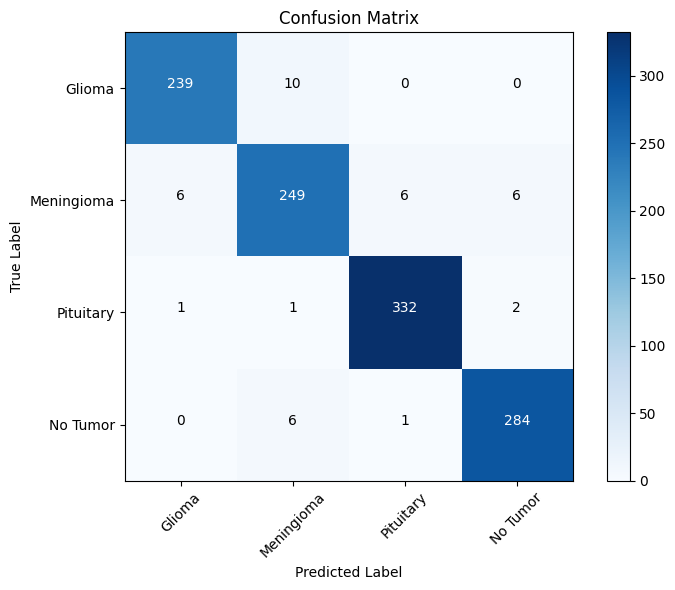

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Initialize variables for correct predictions and total samples
correct = 0
total_samples = 0

# Define class names
class_names = ['Glioma', 'Meningioma', 'Pituitary', 'No Tumor']

# Iterate over the validation dataset to obtain predictions and true labels
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate overall accuracy
overall_accuracy = correct / total_samples

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate precision, recall, and F1-score for each class
precision = precision_score(true_labels, predicted_labels, average=None)
recall = recall_score(true_labels, predicted_labels, average=None)
f1 = f1_score(true_labels, predicted_labels, average=None)

# Calculate overall precision, recall, and F1-score
overall_precision = precision_score(true_labels, predicted_labels, average='weighted')
overall_recall = recall_score(true_labels, predicted_labels, average='weighted')
overall_f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate the number of misclassified images
num_misclassified = np.sum(np.sum(conf_matrix)) - np.trace(conf_matrix)

# Print overall evaluation metrics
print("Overall Evaluation Metrics:")
print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1-score: {overall_f1:.4f}")
print(f"Number of Misclassified Images: {num_misclassified}")
print("\nEvaluation Metrics for Each Class:")
for i, class_name in enumerate(class_names):
    print(f"Class {class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1[i]:.4f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")
plt.tight_layout()
plt.show()


In [ ]:
!pip install timm

# EFFICIENT NET CODE

In [7]:
#EFFICIENT NET CODE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import timm

# Define the root folder containing subfolders for each class
root_data_path = '/kaggle/input/brain-tumor-mri-dataset'

# Define data transformations with increased augmentation and color jitter
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset using ImageFolder
brain_tumor_dataset = datasets.ImageFolder(root=root_data_path + '/Training', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(brain_tumor_dataset))
val_size = len(brain_tumor_dataset) - train_size
train_dataset, val_dataset = random_split(brain_tumor_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Load pre-trained EfficientNet model
model_path = "//kaggle/input/pthfiles/pytorch_model.bin"  # Replace with the path to your downloaded weights
efficientnet = timm.create_model("efficientnet_b0", pretrained=False)
state_dict = torch.load(model_path)
efficientnet.load_state_dict(state_dict)


# Modify EfficientNet classifier to fit the number of classes in your dataset with additional layers and dropout
num_classes = len(brain_tumor_dataset.classes)
efficientnet.classifier = nn.Sequential(
    nn.Dropout(0.6),
    nn.Linear(efficientnet.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.6),
    nn.Linear(512, num_classes)
)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = efficientnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7 , gamma=0.1)

# Training loop with early stopping
prev_val_loss = float('inf')
early_stopping_count = 0
max_early_stopping = 3  # Maximum number of epochs without improvement for early stopping

num_epochs = 10 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}')

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Adjust learning rate
    scheduler.step()

    # Early stopping
    if avg_val_loss >= prev_val_loss:
        early_stopping_count += 1
        if early_stopping_count >= max_early_stopping:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            break
    else:
        early_stopping_count = 0

    prev_val_loss = avg_val_loss

# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_detection_resnet_model.pth')


Epoch 1/10, Average Loss: 1.202578714677504
Epoch 1/10, Validation Loss: 0.8957835568322076, Accuracy: 0.7970253718285214
Epoch 2/10, Average Loss: 0.6323068767160802
Epoch 2/10, Validation Loss: 0.3802073419921928, Accuracy: 0.8766404199475065
Epoch 3/10, Average Loss: 0.356491512872956
Epoch 3/10, Validation Loss: 0.2878942193670405, Accuracy: 0.8993875765529309
Epoch 4/10, Average Loss: 0.2689996964552186
Epoch 4/10, Validation Loss: 0.22483577910396788, Accuracy: 0.9212598425196851
Epoch 5/10, Average Loss: 0.22963027593555985
Epoch 5/10, Validation Loss: 0.1772880881714324, Accuracy: 0.9378827646544182
Epoch 6/10, Average Loss: 0.2019409930945693
Epoch 6/10, Validation Loss: 0.15785467407355705, Accuracy: 0.9457567804024497
Epoch 7/10, Average Loss: 0.1565017576843917
Epoch 7/10, Validation Loss: 0.15052782498403555, Accuracy: 0.9483814523184602
Epoch 8/10, Average Loss: 0.14209503524161718
Epoch 8/10, Validation Loss: 0.11643627296305364, Accuracy: 0.9588801399825022
Epoch 9/10, 

Accuracy: 0.9518810148731408
F1 Score: 0.951595947225654
Recall: 0.9518810148731408
Precision: 0.9514903274863318
Number of misclassified images: 55


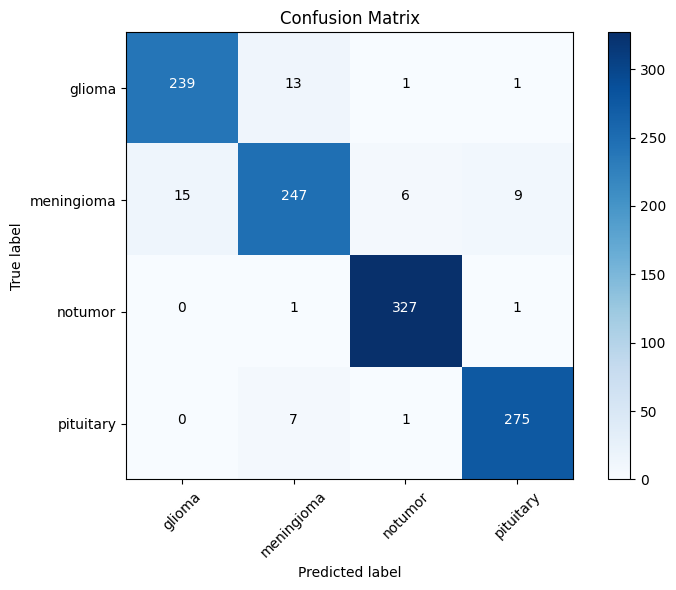

In [20]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Append true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
precision = precision_score(true_labels, predicted_labels, average='weighted')
misclassified_images = np.sum(np.array(true_labels) != np.array(predicted_labels))

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'Number of misclassified images: {misclassified_images}')

# Plot confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
classes = brain_tumor_dataset.classes
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()

# Add values to the confusion matrix plot
thresh = cm.max() / 2.
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.show()


# MOBILE NET CODE

In [11]:
#MOBILE NET CODE
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.models import mobilenet_v2

# Define the root folder containing subfolders for each class
root_data_path = '/kaggle/input/brain-tumor-mri-dataset'

# Define data transformations with increased augmentation and color jitter
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load your dataset using ImageFolder
brain_tumor_dataset = datasets.ImageFolder(root=root_data_path + '/Training', transform=transform)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(brain_tumor_dataset))
val_size = len(brain_tumor_dataset) - train_size
train_dataset, val_dataset = random_split(brain_tumor_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)

# Load pre-trained MobileNetV2 model from local path
mobilenet_weights_path = '/kaggle/input/pthfiles/mobilenet_v2-b0353104.pth'
mobilenet_model = mobilenet_v2(pretrained=False)
mobilenet_model.load_state_dict(torch.load(mobilenet_weights_path))

# Modify the classifier to fit the number of classes in your dataset
num_features = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_features, len(brain_tumor_dataset.classes))  # Assuming len(brain_tumor_dataset.classes) classes

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mobilenet_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5, weight_decay=1e-1)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop with early stopping
prev_val_loss = float('inf')
early_stopping_count = 0
max_early_stopping = 3  # Maximum number of epochs without improvement for early stopping

num_epochs = 10 
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss}')

    # Evaluation on the validation set
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {avg_val_loss}, Accuracy: {val_accuracy}')

    # Adjust learning rate
    scheduler.step()

    # Early stopping
    if avg_val_loss >= prev_val_loss:
        early_stopping_count += 1
        if early_stopping_count >= max_early_stopping:
            print(f'Early stopping after {epoch + 1} epochs without improvement.')
            break
    else:
        early_stopping_count = 0

    prev_val_loss = avg_val_loss

# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_detection_mobilenet_model.pth')


Epoch 1/10, Average Loss: 0.8012944505764887
Epoch 1/10, Validation Loss: 0.4933995066417588, Accuracy: 0.8503937007874016
Epoch 2/10, Average Loss: 0.4162593642314831
Epoch 2/10, Validation Loss: 0.34851788274115986, Accuracy: 0.8871391076115486
Epoch 3/10, Average Loss: 0.3111284101655433
Epoch 3/10, Validation Loss: 0.2699872311204672, Accuracy: 0.9177602799650044
Epoch 4/10, Average Loss: 0.26353796785111194
Epoch 4/10, Validation Loss: 0.2238524721728431, Accuracy: 0.9291338582677166
Epoch 5/10, Average Loss: 0.2132127856041168
Epoch 5/10, Validation Loss: 0.19982375928925145, Accuracy: 0.9422572178477691
Epoch 6/10, Average Loss: 0.18909623489513264
Epoch 6/10, Validation Loss: 0.18394485612710318, Accuracy: 0.9448818897637795
Epoch 7/10, Average Loss: 0.1924772737222118
Epoch 7/10, Validation Loss: 0.1831725521220101, Accuracy: 0.9396325459317585
Epoch 8/10, Average Loss: 0.18806112307560194
Epoch 8/10, Validation Loss: 0.17736604375143847, Accuracy: 0.9431321084864392
Epoch 9/1

Overall Evaluation Metrics:
Accuracy: 0.9492563429571304
F1 Score: 0.9490481934416579
Recall: 0.9492563429571304
Precision: 0.9726
Number of Images Misclassified: 1


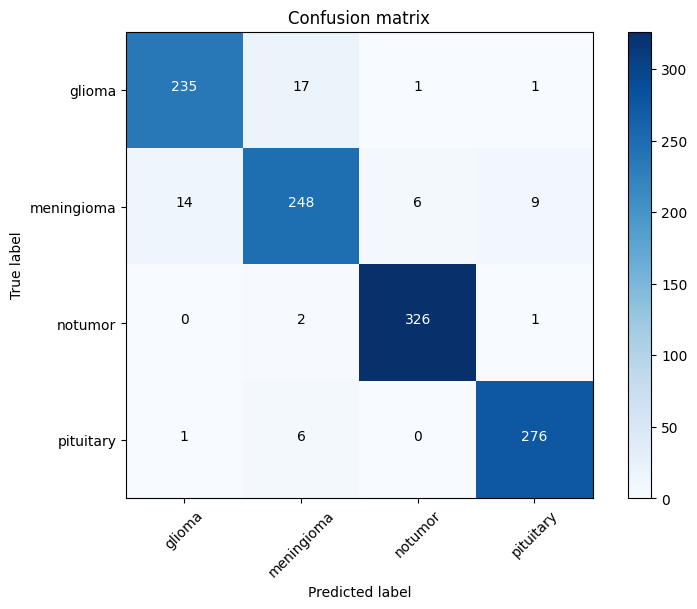

In [18]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import itertools

# Function to calculate evaluation metrics
def calculate_metrics(labels_true, labels_pred):
    accuracy = accuracy_score(labels_true, labels_pred)
    f1 = f1_score(labels_true, labels_pred, average='weighted')
    recall = recall_score(labels_true, labels_pred, average='weighted')
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    misclassified = np.sum(labels_true != labels_pred)
    return accuracy, f1, recall, misclassified

# Function to plot confusion matrix with numbers
def plot_confusion_matrix(labels_true, labels_pred, class_names):
    cm = confusion_matrix(labels_true, labels_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Evaluate the model on the validation set
model.eval()
val_labels_true = []
val_labels_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        val_labels_true.extend(labels.cpu().numpy())
        val_labels_pred.extend(predicted.cpu().numpy())

# Calculate evaluation metrics
accuracy, f1, recall, misclassified = calculate_metrics(val_labels_true, val_labels_pred)
print(f'Overall Evaluation Metrics:')
print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'Recall: {recall}')
print(f"Precision: {precision[i]:.4f}")
print(f'Number of Images Misclassified: {misclassified}')

# Plot confusion matrix with numbers
class_names = brain_tumor_dataset.classes
plot_confusion_matrix(val_labels_true, val_labels_pred, class_names)
